# NPP vs Control
### units of NPP, I think we want (g C $m^{−2}$ $yr^{−1}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [6]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

In [7]:
new = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [10]:
obsfiles = sorted(glob.glob('/glade/work/jluo/obs/NPP/Multimodel_mean/multimodel_clim_*_x1v6.nc', recursive=True),
                      key=numericalSort)
obs = xr.open_mfdataset(obsfiles,combine='by_coords')

In [14]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [12]:
# MARBL SPECTRA NPP
total_npp = new.photoC_TOT.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2 s-1
total_npp = total_npp.mean(dim='time') * (60*60*24*365) # mmol m-2 y-1
total_npp = total_npp * 12.011 / 1e3 # gC m-2 y-1

In [13]:
## Obserations NPP
obs_npp = obs.NPP.mean(axis=0)/1e3 # gC m-2 day-1 
obs_npp = obs_npp *365 # gC m-2 y-1

In [14]:
# colors
lev = (0,50,100,150, 200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=500)

<Figure size 1440x576 with 0 Axes>

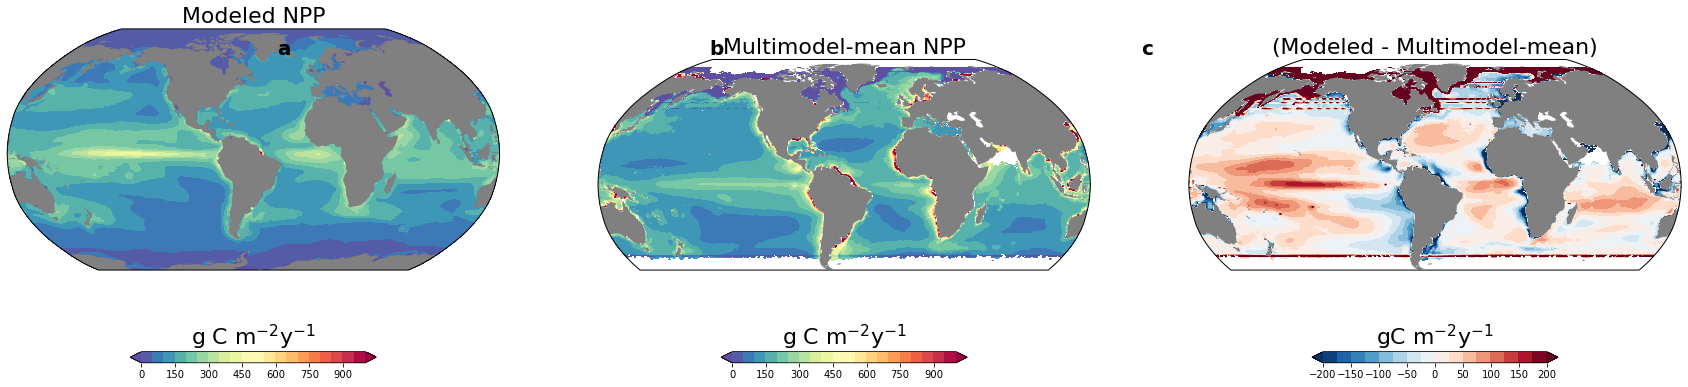

In [15]:
fig = plt.figure(figsize=(20, 8))

levv = (-200,-175,-150,-125, -100,-75,-50,-25,0,25,50,75,100,125,150,175,200)
#levels = (0,100,500,1000)

fig = plt.figure(figsize=(30, 10))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, total_npp)
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=1000,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, chln, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('g C $m^{-2} y^{-1}$', fontsize = 22)
ax.set_title('Modeled NPP', fontsize = 22);
fig.text(0.25, 0.65, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(new.TLONG, new.TLAT, obs_npp)
cf = ax.contourf(lon, lat, chlno,vmin=0, vmax=1000,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, chlno, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('g C $m^{-2} y^{-1}$', fontsize = 22)
ax.set_title('Multimodel-mean NPP', fontsize = 22);
fig.text(0.45, 0.65, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln-chlno, cmap='RdBu_r',vmin = -200, vmax =200, levels=levv, extend='both',transform=ccrs.PlateCarree());
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2} y^{-1}$', fontsize = 22)
ax.set_title('(Modeled - Multimodel-mean)', fontsize = 22);
fig.text(0.65, 0.65, 'c',fontsize=20, fontweight='bold')
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NPP_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Create a plot of NPP, for small medium and large phytoplankton to comare with long et al. 2021

In [19]:
pp1 = new.photoC_pp_zint_100m + new.photoC_mp1_zint_100m
mp1 = new.photoC_mp3_zint_100m + new.photoC_mp4_zint_100m+ new.photoC_diat3_zint_100m+ new.photoC_diat2_zint_100m
np1 = new.photoC_diat1_zint_100m +  new.photoC_mp2_zint_100m+ new.photoC_diaz_zint_100m

In [20]:
pp1 = pp1.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
mp1 = mp1.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
np1 = np1.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1

In [21]:
pp1.shape

(384, 320)

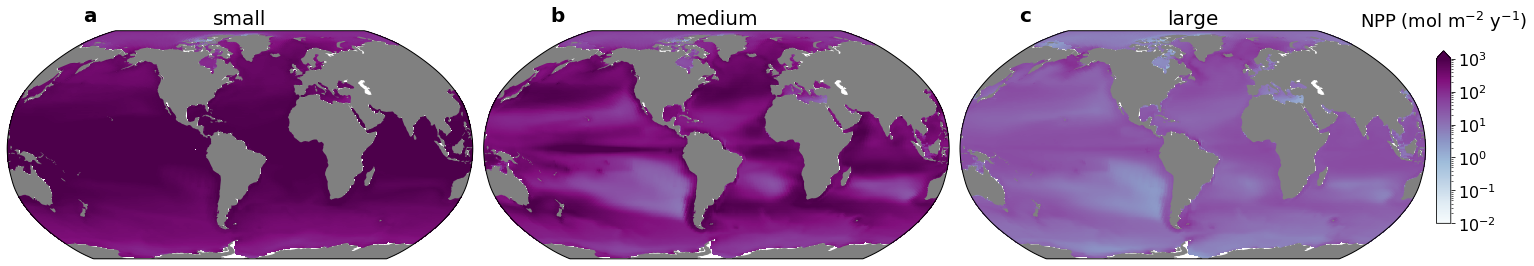

In [35]:
lev = np.arange(0,400,50)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)

fig = plt.figure(figsize=(20, 8))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, mp1)
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolormesh(lon, lat, chln, norm=colors.LogNorm(vmin=0.01, vmax=1000),cmap='BuPu', shading='auto',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('large', fontsize=20);
fig.text(0.385, 0.95, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np1)
cf = ax.pcolormesh(lon, lat, chln, norm=colors.LogNorm(vmin=0.01, vmax=1000),cmap='BuPu', shading='auto',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('medium', fontsize=20);
fig.text(0.06, 0.95, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, pp1)
cf = ax.pcolormesh(lon, lat, chln, norm=colors.LogNorm(vmin=0.01, vmax=1000),cmap='BuPu', shading='auto',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('small', fontsize=20);
fig.text(0.71, 0.95, 'c',fontsize=20, fontweight='bold')

cb_ax = fig.add_axes([1, 0.6, 0.01, 0.3])
cbar = fig.colorbar(cf, extend='max',cax=cb_ax, shrink=0.5)
cbar.ax.set_title('NPP (mol m$^{-2}$ y$^{-1}$)', fontsize = 18, y=1.25, pad=-20)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NPP_phytoplankton.png',dpi=600, bbox_inches='tight')

## Fraction of NPP for each phytoplankton to total NPP. 

In [9]:
# MARBL SPECTRA NPP
total_npp = new.photoC_TOT_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
pp = new.photoC_pp_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
mp1 = new.photoC_mp1_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
mp2 = new.photoC_mp2_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
mp3 = new.photoC_mp3_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
mp4 = new.photoC_mp4_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
diat1 = new.photoC_diat1_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
diat2 = new.photoC_diat2_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
diat3 = new.photoC_diat3_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1
diaz = new.photoC_diaz_zint_100m.mean(dim='time') * (60*60*24*365)/1000 # mol m-2 y-1

In [43]:
from tabulate import tabulate
fig = plt.figure(figsize=(5, 6))
print(tabulate([['total NPP', np.format_float_scientific(np.nanmean(total_npp),2),'100 %'], 
                ['picoplankton', np.format_float_scientific(np.nanmean(pp),2),(np.nanmean(pp)/np.nanmean(total_npp))*100],
                ['mixed phytoplankton 1',np.format_float_scientific(np.nanmean(mp1),2),(np.nanmean(mp1)/np.nanmean(total_npp))*100],
                ['mixed phytoplankton 2',np.format_float_scientific(np.nanmean(mp2),2),(np.nanmean(mp2)/np.nanmean(total_npp))*100],
                ['mixed phytoplankton 3',np.format_float_scientific(np.nanmean(mp3),2),(np.nanmean(mp3)/np.nanmean(total_npp))*100],
                ['mixed phytoplankton 4',np.format_float_scientific(np.nanmean(mp4),2),(np.nanmean(mp4)/np.nanmean(total_npp))*100],
                ['diatom 1',np.format_float_scientific(np.nanmean(diat1),2),(np.nanmean(diat1)/np.nanmean(total_npp))*100],
                ['diatom 2',np.format_float_scientific(np.nanmean(diat2),2),(np.nanmean(diat2)/np.nanmean(total_npp))*100],
                ['diatom 3',np.format_float_scientific(np.nanmean(diat3),2),(np.nanmean(diat3)/np.nanmean(total_npp))*100],
                ['diazotroph',np.format_float_scientific(np.nanmean(diaz),2),(np.nanmean(diaz)/np.nanmean(total_npp))*100]],
               headers=['NPP', 'Global mean (mol m-2 y-1)','% NPP']));

#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/'+new_file+'_'+year+'year.png')

NPP                      Global mean (mol m-2 y-1)  % NPP
---------------------  ---------------------------  -------------------
total NPP                                 1140      100 %
picoplankton                               664      58.07259163201744
mixed phytoplankton 1                      140      12.212873109059954
mixed phytoplankton 2                        6.76   0.5904265802049984
mixed phytoplankton 3                        1.93   0.16873162810453782
mixed phytoplankton 4                        0.463  0.04042322570403061
diatom 1                                   293      25.594322735607054
diatom 2                                    16.8    1.4643084282636039
diatom 3                                     4.63   0.4048038743344652
diazotroph                                  16.6    1.451518813734752


<Figure size 360x432 with 0 Axes>

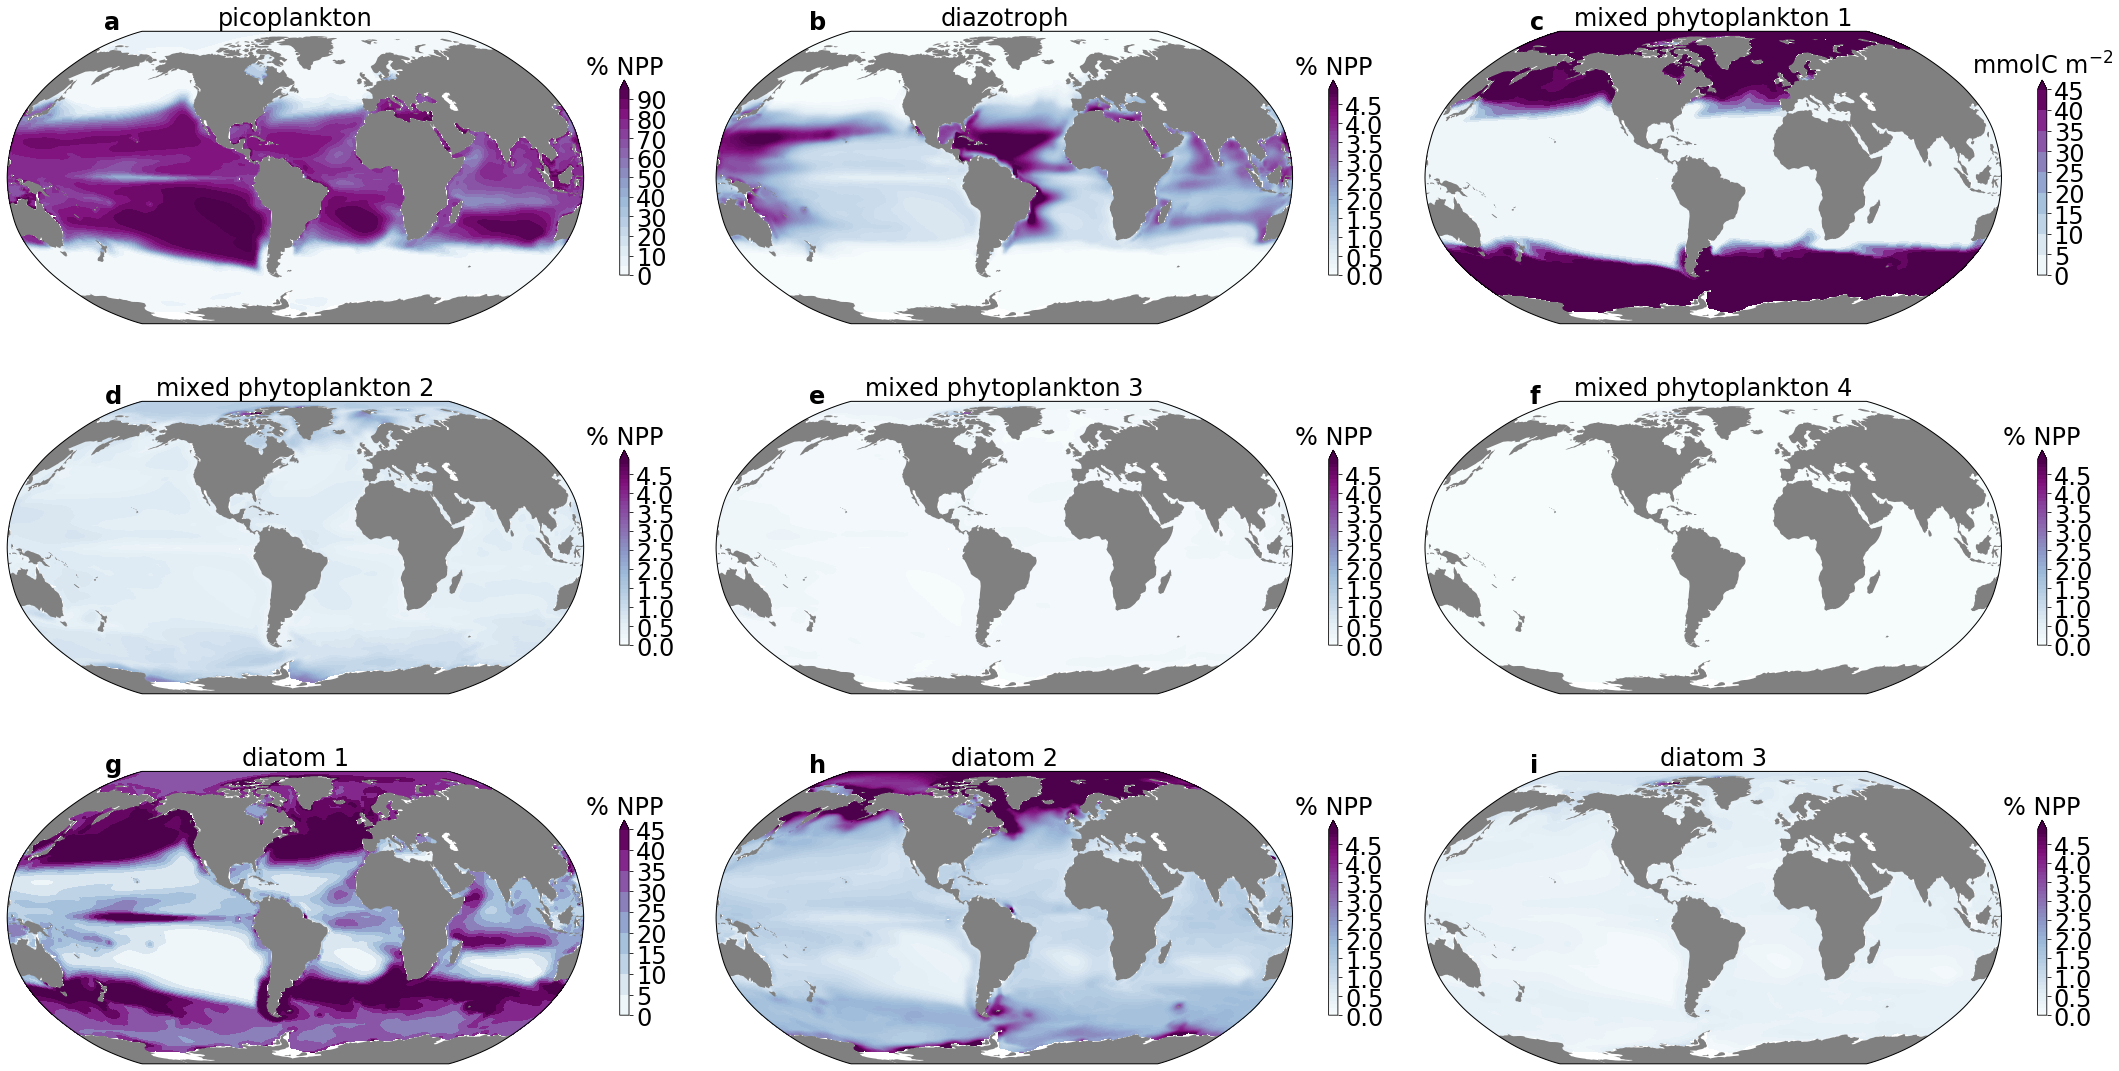

In [24]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
lev = np.arange(0, 100, 5)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
x, y, pp_npp = adjust_pop_grid(new.TLONG, new.TLAT, (pp/total_npp)*100)
cf = ax.contourf(x, y, pp_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
ax.set_global()
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 5, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
x, y, diaz_npp = adjust_pop_grid(new.TLONG, new.TLAT, (diaz/total_npp)*100)
cf = ax.contourf(x, y, diaz_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diazotroph', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 50, 5)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=25)
x, y, mp1_npp = adjust_pop_grid(new.TLONG, new.TLAT, (mp1/total_npp)*100)
cf = ax.contourf(x, y, mp1_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 5, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
x, y, mp2_npp = adjust_pop_grid(new.TLONG, new.TLAT, (mp2/total_npp)*100)
cf = ax.contourf(x, y, mp2_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 5, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
x, y, mp3_npp = adjust_pop_grid(new.TLONG, new.TLAT, (mp3/total_npp)*100)
cf = ax.contourf(x, y, mp3_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 5, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
x, y, mp4_npp = adjust_pop_grid(new.TLONG, new.TLAT, (mp4/total_npp)*100)
cf = ax.contourf(x, y, mp4_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 50, 5)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=25)
x, y, diat1_npp = adjust_pop_grid(new.TLONG, new.TLAT, (diat1/total_npp)*100)
cf = ax.contourf(x, y, diat1_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 5, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
x, y, diat2_npp = adjust_pop_grid(new.TLONG, new.TLAT, (diat2/total_npp)*100)
cf = ax.contourf(x, y, diat2_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diatom 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
lev = np.arange(0, 5, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
x, y, diat3_npp = adjust_pop_grid(new.TLONG, new.TLAT, (diat3/total_npp)*100)
cf = ax.contourf(x, y, diat3_npp, cmap='BuPu', levels = lev,norm=norm,extend='max', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'max')
cbar.ax.set_title('% NPP', fontsize = 24)
fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)
fig.tight_layout()
plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NPP_fraction_phyto.png',dpi=600, bbox_inches='tight')

## Create a scatter plot

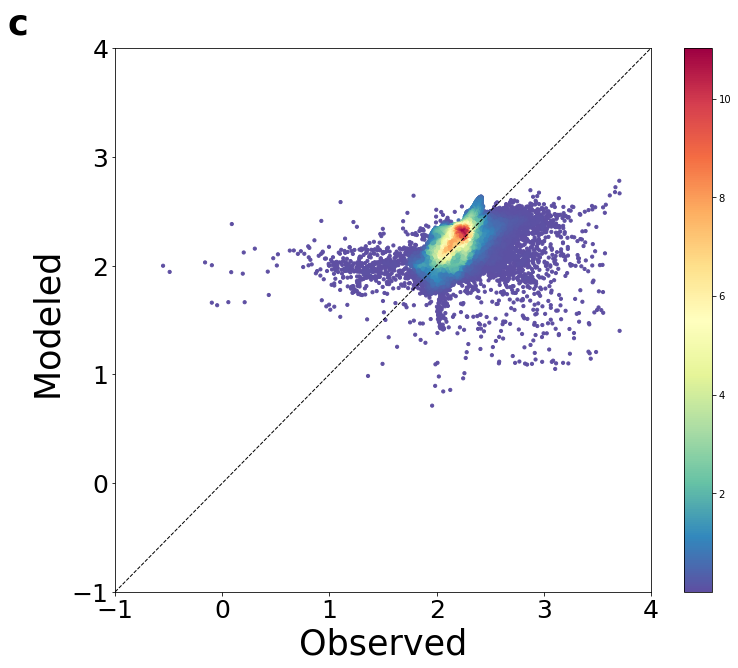

In [14]:
from scipy import stats
from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(12, 10))
X=np.log10(np.array(obs_npp))[~np.isnan(np.log10(np.array(obs_npp)))& ~np.isnan(np.log10(np.array(total_npp)))]
Y=np.log10(np.array(total_npp))[~np.isnan(np.log10(np.array(obs_npp)))& ~np.isnan(np.log10(np.array(total_npp)))]

# Calculate the 
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([-1, 4], [-1, 4], color='k', linestyle='--', linewidth=1)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Observed', fontsize=35)
plt.ylabel('Modeled ',fontsize = 35)
fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
plt.colorbar()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NPP_scatter'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Now compare with Biomes

In [15]:
biome_mask = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124.nc')

region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

In [16]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [17]:
nbiome = len(biome_mask.region.values)
nt = len(obs.time.values)

In [18]:
# MARBL SPECTRA NPP
total_npp = new.photoC_TOT.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2 s-1
total_npp = total_npp * (60*60*24*365) # mmol m-2 y-1
total_npp = total_npp * 12.011 / 1e3 # gC m-2 y-1

In [19]:
## Obserations NPP
obs_npp = obs.NPP/1e3 # gC m-2 day-1 
obs_npp = obs_npp *365 # gC m-2 y-1

### Calculate observations and satellite data at each region of the biome

In [20]:
index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,2))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=r).values == 1)

    for t in range(nt):
        tmp_obs = total_npp.isel(time=t).values[region]
        biome_means[t,i,1] = np.nanmean(tmp_obs)
        
        tmp_sat = obs_npp.isel(time=t).values[region]
        biome_means[t,i,0] = np.nanmean(tmp_sat)


In [25]:
obs_npp.shape

(12, 384, 320)

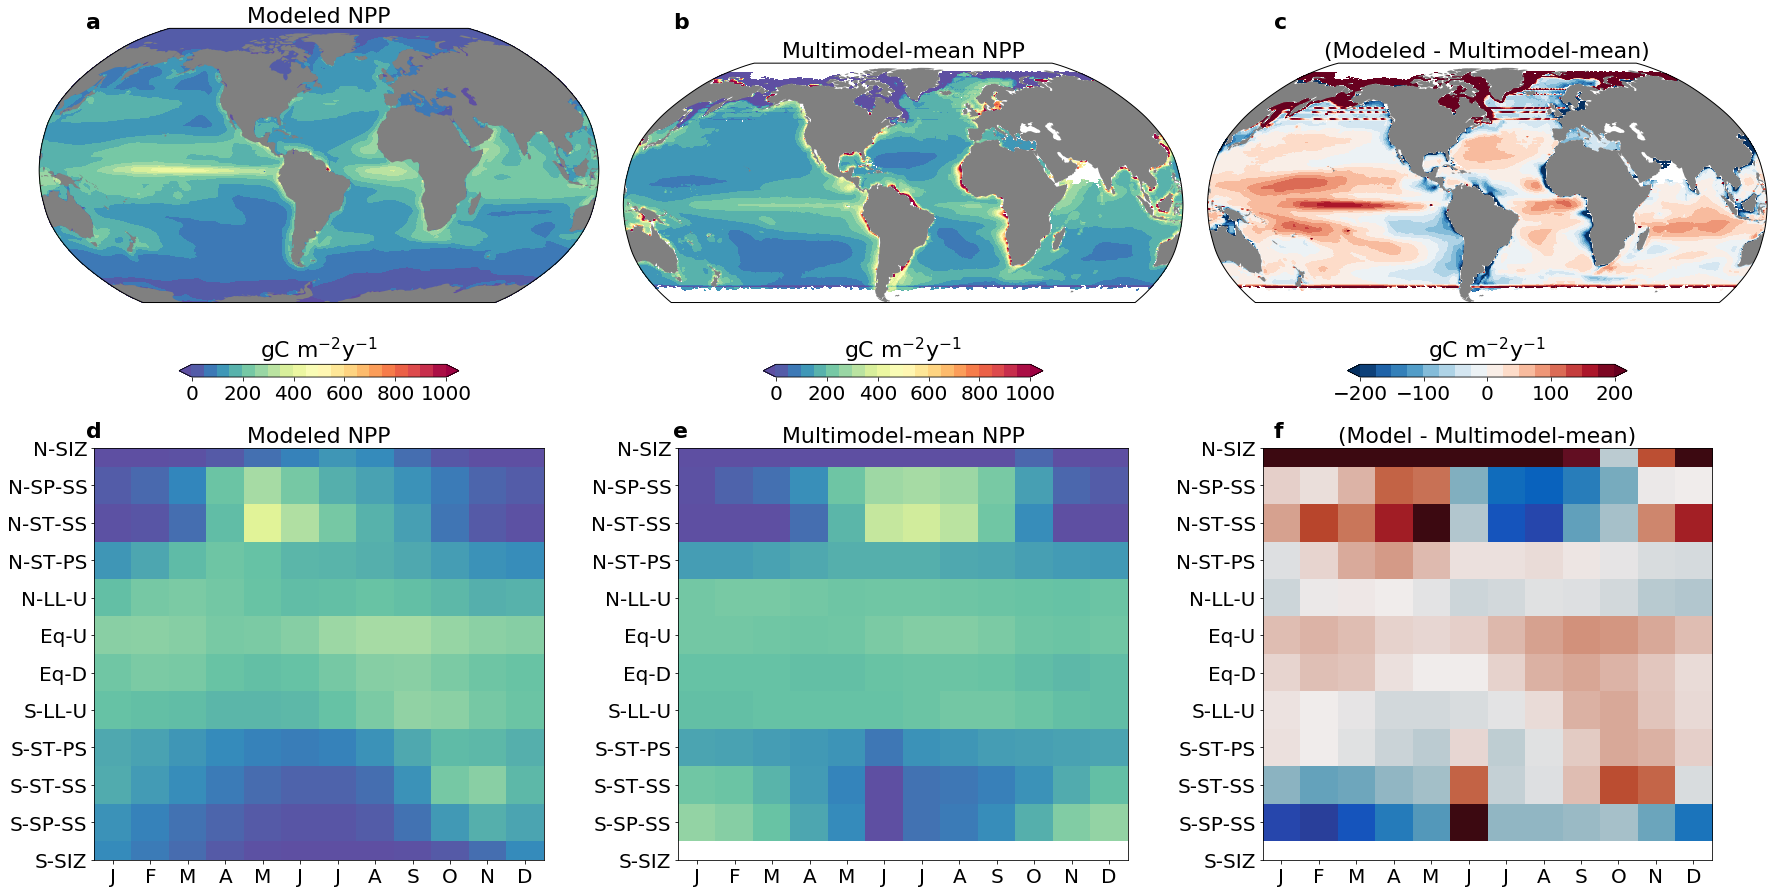

In [30]:
fig = plt.figure(figsize=(25, 12.5))

levv = (-200,-175,-150,-125, -100,-75,-50,-25,0,25,50,75,100,125,150,175,200)

lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=1001,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, chln, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,200,400,600,800,1000],shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('gC $m^{-2} y^{-1}$', fontsize = 22)
ax.set_title('Modeled NPP', fontsize = 22);
fig.text(0.06, 0.965, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(obs_npp,axis=0))
cf = ax.contourf(lon, lat, chlno,vmin=0, vmax=1001,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, chlno, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,200,400,600,800,1000],shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('gC $m^{-2} y^{-1}$', fontsize = 22)
ax.set_title('Multimodel-mean NPP', fontsize = 22);
fig.text(0.3862, 0.965, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln-chlno, cmap='RdBu_r',vmin = -200, vmax =200, levels=levv, extend='both',transform=ccrs.PlateCarree());
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-200,-100,0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('gC $m^{-2} y^{-1}$', fontsize = 22)
ax.set_title('(Modeled - Multimodel-mean)', fontsize = 22);
fig.text(0.72, 0.965, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmax=1000,vmin=0,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Multimodel-mean NPP', fontsize=22)
fig.text(0.06, 0.51, 'd',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmax=1000,vmin=0,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled NPP', fontsize=22)
fig.text(0.386, 0.51, 'e',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmax=200, vmin=-200, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('(Model - Multimodel-mean)', fontsize=22);
fig.text(0.72, 0.51, 'f',fontsize=22, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NPP_top150m_seasonal'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [ ]:
Models = ['Obs.', 'SPECTRA']

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(20,5))

for i in range(2):    
    f = plt.subplot(gs[0,i])
    plt.imshow(biome_means[:,:,i].T, vmax=1000,vmin=0,cmap='Spectral_r')
    plt.yticks(range(nbiome), region_NtoS_names)
    plt.xlabel('Month')
    plt.colorbar()
    plt.title(Models[i] + ' NPP')

# bias plot
f = plt.subplot(gs[0,2])
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmax=200, vmin=-200, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xlabel('Month')
plt.title('(Modeled - Multimodel-mean)')
plt.colorbar()


plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NPP_seasonal_comparison_biomes'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')